In [6]:
#импорируем все необходимые библиотеки
from pandas import Series 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore") 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Функция для визуализации confusion_matrix
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [14]:
# Функция для вывода метрик для оценки качества модели
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df)

In [18]:
# загружаем исходные данные 

train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [19]:
# Посмотрим на случайные 5 строк обучающей базы
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
52010,69927,18MAR2014,GRD,F,23,Y,N,0,1,-1.518010,1,60,2,3,70000,1,4,N,0
39464,108924,29APR2014,GRD,M,27,Y,Y,2,0,-2.729800,3,80,2,3,85000,1,3,Y,0
62562,53518,02MAR2014,UGR,M,59,Y,Y,0,0,-1.599533,0,60,2,3,100000,1,3,Y,0
3093,80373,28MAR2014,GRD,M,44,N,N,0,0,-2.867592,0,50,1,3,70000,1,4,N,0
45842,86547,03APR2014,SCH,F,24,N,N,0,0,-1.873626,0,80,2,3,20000,1,4,Y,0


In [20]:

# Посмотрим на случайные 5 строк тестовой базы
test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
24456,68263,17MAR2014,GRD,F,27,N,N,7,0,-0.482722,6,80,2,3,60000,1,3,Y
22415,16178,23JAN2014,SCH,M,41,N,N,0,0,-1.668129,1,80,2,3,60000,1,3,N
5067,31879,07FEB2014,SCH,F,24,N,N,0,0,-2.169664,2,40,2,3,16000,3,3,N
24328,96946,14APR2014,SCH,F,56,N,N,1,0,-1.836782,7,70,2,3,60000,1,3,N
1944,64802,13MAR2014,GRD,F,67,Y,N,0,0,-1.833391,3,50,1,2,18000,1,3,N



Описание признаков:

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
score_bki - скоринговый балл по данным из БКИ
region_rating - рейтинг региона
app_date - дата подачи заявки
default - флаг дефолта по кредиту

In [22]:
# Посмотрим на первые 10 строк sample_submission
sample_submission.head(10)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
5,175,0.311599
6,57558,0.584807
7,88407,0.815792
8,79183,0.325037
9,69300,0.094011


In [24]:
# Информация об обучающей базе
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [25]:
# Информация о тестовой базе
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [26]:
# Статистическая информация об обучающей базе
train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [27]:
# Статистическая информация о тестовой базе
test.describe()


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


Предобработка данных


In [28]:
# Посмотрим на рапределение целевой переменной
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [29]:
# Количество пропусков в обучающей базе
train.isna().sum()

# Количество пропусков в обучающей базе
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

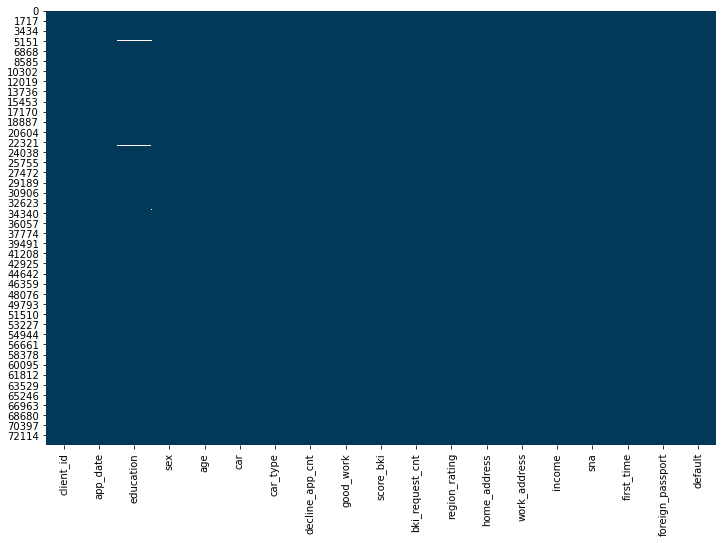

In [30]:
# Графическое отображение нахождения пропусков в обучающей базе
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(train.isna(),cbar=False, cmap ='PuBu_r')

In [31]:
# Количество пропусков в тестовой базе
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

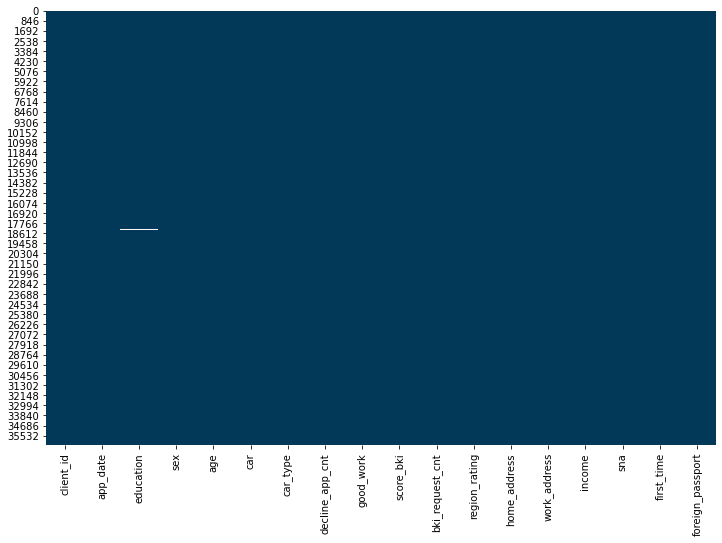

In [32]:
# Графическое отображение нахождения пропусков в тестовой базе
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(test.isna(),cbar=False, cmap ='PuBu_r')

<AxesSubplot:>

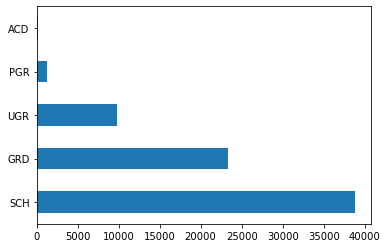

In [33]:
# Гистограмма значений признака education, содержащего пропуски, в обучающей базе
train.education.value_counts().plot.barh()

<AxesSubplot:>

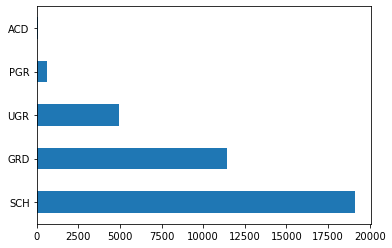

In [34]:
# Гистограмма значений признака education, содержащего пропуски, в тестовой базе
test.education.value_counts().plot.barh()

In [35]:
# Избавимся от пропусков
train['education'].fillna('empty', inplace=True)
test['education'].fillna('empty', inplace=True)

In [36]:
# Выведем наименования всех признаков обучающей базы
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

Разбиваем признаки по трем типам и создаем соответствующие списки (исключая client_id, app_date)

In [37]:
# числовые 
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

# категориальные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

# бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

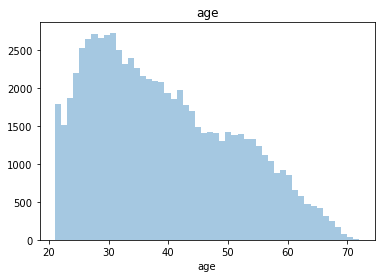

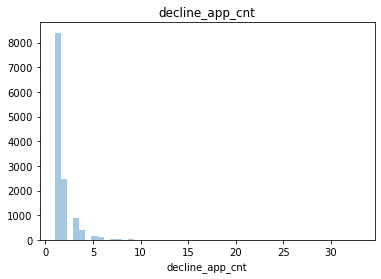

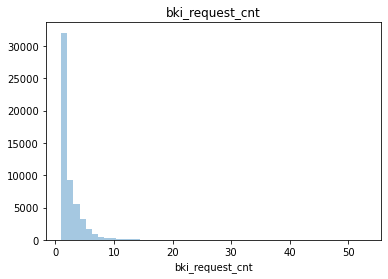

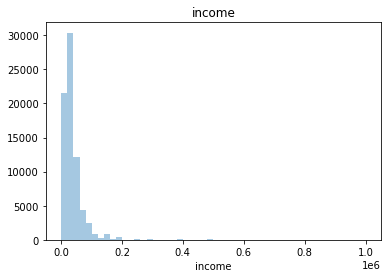

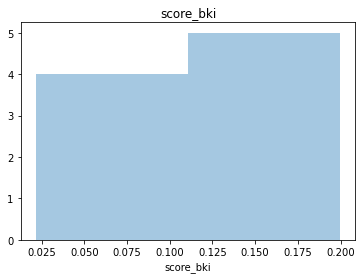

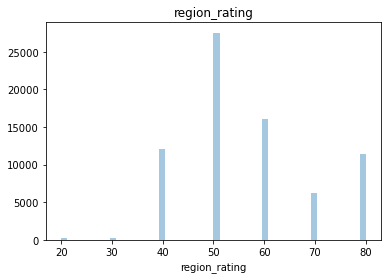

In [38]:
# Графики распределений числовых признаков
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

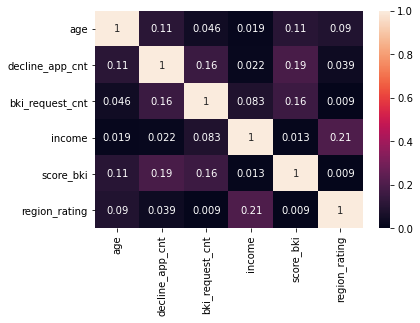

In [39]:
# Посмотрим на тепловую карту числовых признаков
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Распределение числовых признаков 'age', 'bki_request_cnt', 'income' смещено, необходимо будет их прологарифмировать

<AxesSubplot:>

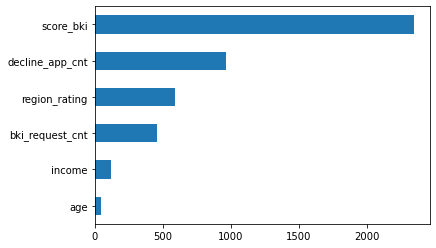

In [40]:
# Посмотрим значимость числовых признаков
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Бинарные и категориальные признаки

In [41]:
# Для бинарных признаков мы будем использовать LabelEncoder, чтобы избавится от строковых значений

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])

In [42]:
# посмотрим как выглядит обучающая база после изменений
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
34012,59071,07MAR2014,UGR,1,34,1,0,1,0,-1.490090,5,50,2,3,55000,4,3,0,1
32184,75916,24MAR2014,SCH,0,42,0,0,0,0,-2.619809,0,50,1,1,23000,1,4,0,0
8372,69064,17MAR2014,SCH,1,37,1,0,6,0,-1.451349,3,80,2,3,80000,4,1,0,0
12309,90635,07APR2014,SCH,1,26,1,0,0,0,-1.812774,3,60,1,2,15000,3,1,0,0
38922,98984,16APR2014,SCH,0,41,0,0,0,0,-2.143486,9,50,2,3,60000,1,3,0,0


In [43]:
# Заменим значения признака education числами в обучающей базе
education_dict = {'ACD': 4, 'PGR': 3, 'UGR': 2, 'GRD': 13, 'SCH': 0, 'empty': 0}
train.education = train['education'].map(education_dict)

train.education.value_counts()

0     39167
13    23365
2      9816
3      1257
4       194
Name: education, dtype: int64

In [44]:
# Заменим значения признака education числами в тестовой базе
test.education = test['education'].map(education_dict)

test.education.value_counts()

0     19309
13    11403
2      4932
3       608
4        97
Name: education, dtype: int64

In [45]:
# Переведем даты из признака app_date к типу datetime 
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [46]:
# Посмотрим количество уникальных годов в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.year).value_counts()

2014    73799
Name: app_date, dtype: int64

In [47]:
# Посмотрим количество уникальных годов в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.year).value_counts()

2014    36349
Name: app_date, dtype: int64

In [48]:
# Посмотрим количество уникальных месяцев в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.month).value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64

In [49]:
# Посмотрим количество уникальных месяцев в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.month).value_counts()

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

Создание новых признаков

In [50]:
# Новый признак месяца подачи заявления на кредит
train['month'] = train.app_date.apply(lambda x: x.month)
test['month'] = train.app_date.apply(lambda x: x.month)

cat_cols.append('month')

In [51]:
# Новый признак количество дней между датой подачи заявления на кредит и датой первой подачи в базе
train['days'] = (train.app_date - train.app_date.min()).dt.days
test['days'] = (test.app_date - test.app_date.min()).dt.days

num_cols.append('days')

In [52]:
# посмотрим на ифнормацию по базам после изменений  
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73799 non-null  int64         
 3   sex               73799 non-null  int32         
 4   age               73799 non-null  int64         
 5   car               73799 non-null  int32         
 6   car_type          73799 non-null  int32         
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [53]:
# Также добавим новые признаки, потенциально способные улучшить результаты модели
train['bki_age_reg'] = (train['score_bki']/train['age'])*train['region_rating']
test['bki_age_reg'] = (test['score_bki']/test['age'])*test['region_rating']

train['mult_sna_ftime'] = train['sna'] * train['first_time']
test['mult_sna_ftime'] = test['sna'] * test['first_time']

train['edu_and_income'] = (train['education'] + 1) * train['income']
test['edu_and_income'] = (test['education'] + 1) * test['income']

train['success_client'] = (train['foreign_passport'] + 1) * (train['good_work'] + 1) * (train['car'] + 1)
test['success_client'] = (test['foreign_passport'] + 1) * (test['good_work'] + 1) * (test['car'] + 1)

train['very_success_client'] = train['foreign_passport'] * train['good_work'] * train['car']
test['very_success_client'] = test['foreign_passport'] * test['good_work'] * test['car']

train['fpassp_and_gwork'] = train['foreign_passport'] * train['good_work'] 
test['fpassp_and_gwork'] = test['foreign_passport'] * test['good_work']

train['fpassp_and_car'] = train['foreign_passport'] * train['car']
test['fpassp_and_car'] = test['foreign_passport'] * test['car']

train['gwork_and_car'] = train['good_work'] * train['car']
test['gwork_and_car'] = test['good_work'] * test['car']

In [54]:
# Добавляем новые признаки в соответствующие списки
num_cols.append('bki_age_reg')
num_cols.append('mult_sna_ftime')
num_cols.append('edu_and_income')
cat_cols.append('success_client')
bin_cols.append('very_success_client')
bin_cols.append('fpassp_and_gwork')
bin_cols.append('fpassp_and_car')
bin_cols.append('gwork_and_car')

In [55]:
#Посмотрим на распределение значений decline_app_cnt в обучающей выборке
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

In [56]:
# изменим значения признака decline_app_cnt, которые встречаются наиболее редко, единственным значением
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)

In [57]:
# Изменяем принадлежность к списку признаку decline_app_cnt
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [59]:
# Теперь прологарифмируем численные переменные, распределение которых смещено 

num_cols_log = ['age', 'bki_request_cnt', 'income']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    
    
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

Визуализируем признаки


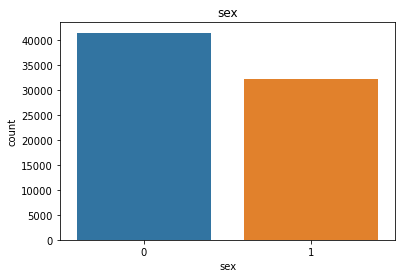

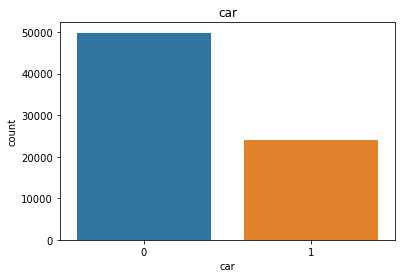

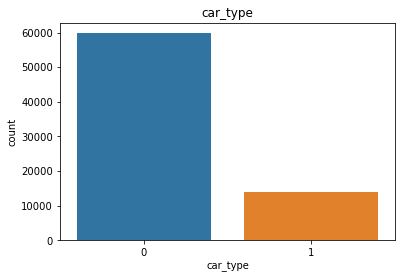

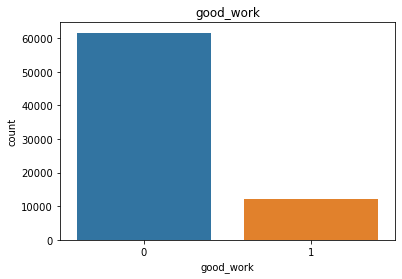

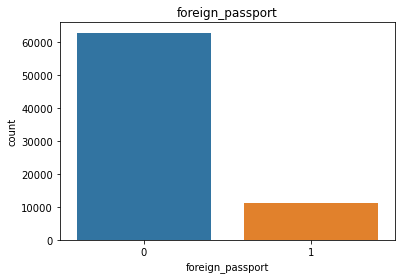

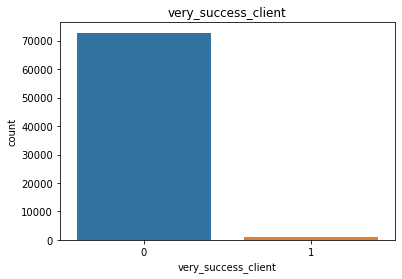

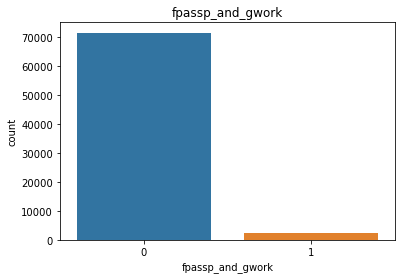

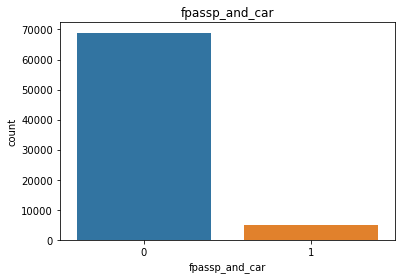

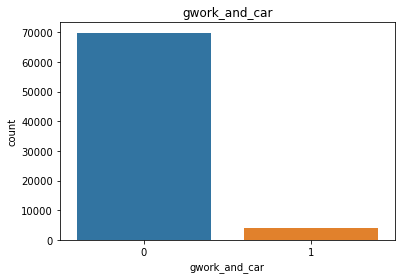

In [60]:
# Посмотрим на гистограммы распределения бинарных признаков
for column in bin_cols:
    plt.figure()
    sns.countplot(train[column])
    plt.title(column)
    plt.show()

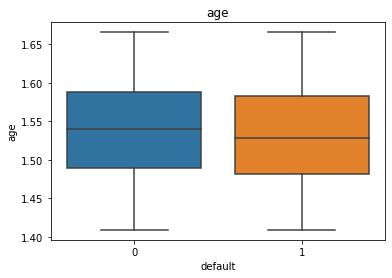

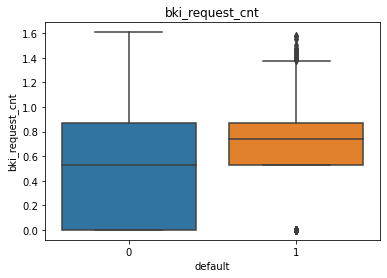

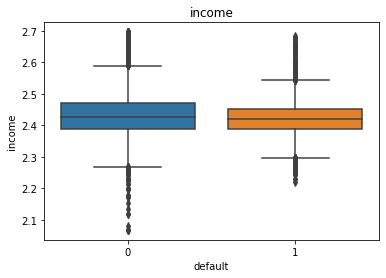

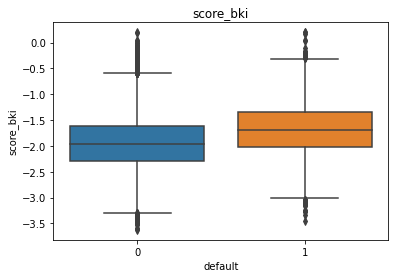

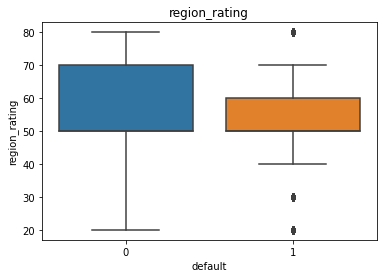

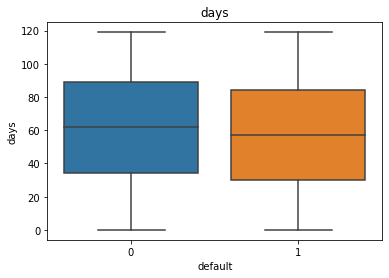

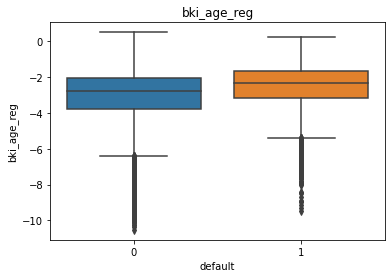

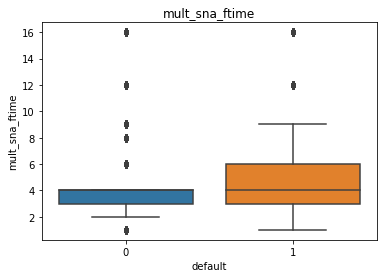

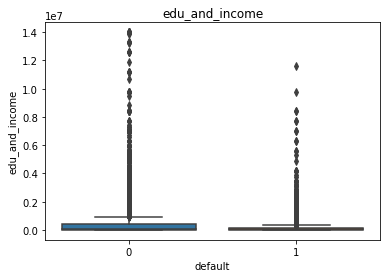

In [61]:
# boxplots числовых признаков
for column in num_cols:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[column])
    plt.title(column)
    plt.show()

<AxesSubplot:>

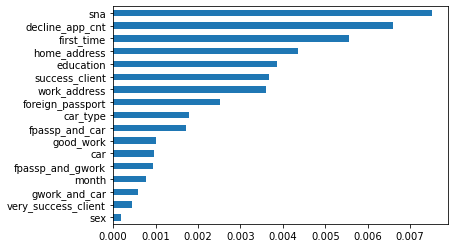

In [62]:
# оценим значимость бинарных и категориальных переменных
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Text(0.5, 0, 'F-value')

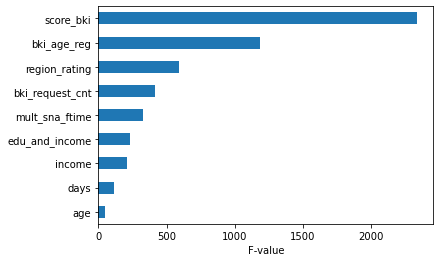

In [63]:
# еще раз посмотрим на значимость числовых переменных
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.xlabel('F-value')

In [64]:
# посмотрим на корреляцию признаков обучающей базы
corr_train = train.drop(['client_id', 'education'],axis = 1).corr()
corr_train.style.background_gradient(cmap='coolwarm').set_precision(3)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,days,bki_age_reg,mult_sna_ftime,edu_and_income,success_client,very_success_client,fpassp_and_gwork,fpassp_and_car,gwork_and_car
sex,1.000,-0.125,0.279,0.226,0.023,-0.040,-0.045,-0.045,0.108,0.038,0.069,0.307,-0.004,0.014,0.086,0.020,-0.030,-0.033,-0.147,0.012,0.121,0.173,0.050,0.028,0.129,0.065
age,-0.125,1.000,-0.033,-0.031,-0.126,-0.072,-0.110,0.045,-0.091,-0.002,-0.017,-0.094,-0.073,0.099,-0.036,-0.026,0.015,0.017,0.602,-0.036,-0.015,-0.066,-0.022,-0.045,-0.008,-0.047
car,0.279,-0.033,1.000,0.698,-0.036,0.002,-0.045,-0.050,0.065,-0.025,-0.008,0.322,-0.072,0.090,0.108,-0.043,-0.020,-0.022,-0.065,-0.003,0.197,0.599,0.172,0.050,0.385,0.344
car_type,0.226,-0.031,0.698,1.000,-0.048,0.018,-0.040,-0.023,0.104,-0.012,0.001,0.365,-0.086,0.104,0.146,-0.057,-0.025,-0.027,-0.084,-0.007,0.257,0.483,0.181,0.077,0.370,0.267
decline_app_cnt,0.023,-0.126,-0.036,-0.048,1.000,-0.030,0.203,0.104,-0.040,0.011,0.017,-0.011,0.069,-0.074,-0.030,0.121,-0.022,-0.023,0.061,0.027,-0.041,-0.051,-0.024,-0.025,-0.036,-0.025
good_work,-0.040,-0.072,0.002,0.018,-0.030,1.000,0.006,0.006,0.073,-0.004,-0.009,0.053,-0.054,0.056,0.046,-0.043,0.005,0.005,-0.081,-0.013,0.081,0.523,0.269,0.402,0.034,0.537
score_bki,-0.045,-0.110,-0.045,-0.040,0.203,0.006,1.000,0.125,0.009,0.014,0.013,0.004,0.068,-0.069,-0.022,0.175,-0.062,-0.064,0.499,0.040,-0.022,-0.036,-0.018,-0.013,-0.033,-0.014
bki_request_cnt,-0.045,0.045,-0.050,-0.023,0.104,0.006,0.125,1.000,-0.022,0.002,-0.002,0.068,0.012,0.007,-0.008,0.075,-0.002,-0.000,0.104,0.025,0.042,-0.028,-0.012,-0.007,-0.017,-0.012
region_rating,0.108,-0.091,0.065,0.104,-0.040,0.073,0.009,-0.022,1.000,0.234,0.254,0.312,-0.078,0.089,0.255,-0.089,0.005,0.007,-0.548,-0.017,0.169,0.207,0.101,0.148,0.174,0.067
home_address,0.038,-0.002,-0.025,-0.012,0.011,-0.004,0.014,0.002,0.234,1.000,0.728,0.045,0.115,-0.058,0.039,0.085,0.169,0.164,-0.117,0.062,0.029,0.011,0.019,0.028,0.022,-0.002


In [65]:
# Признаки с высокой корреляцией удалим (выше 0.8 по модулю)
cat_cols.remove('month')

Подготовим модель

In [66]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [68]:
# Стандартизация числовых непрерывных переменных на обучающей базе

X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.65533216, -0.09524766, -0.77798224, ...,  0.98851239,
        -0.08042749, -0.45721178],
       [ 1.4999249 ,  0.81111707, -0.6963564 , ...,  1.22122567,
        -0.08042749, -0.45547599],
       [-1.4235564 , -0.09524766, -0.02257578, ..., -1.10104712,
        -0.08042749, -0.43638224],
       ...,
       [-0.64728574,  1.04723006,  0.55312826, ..., -0.66484442,
        -0.08042749, -0.41034531],
       [-0.88463179,  0.81111707, -1.27807247, ...,  0.3147392 ,
         0.73304037, -0.46589076],
       [-0.32335567,  0.47180311, -0.28820487, ...,  0.28245698,
        -0.48716142,  0.11907224]])

In [70]:
# Стандартизация числовых непрерывных переменных на тестовой базе

Y_num = StandardScaler().fit_transform(test[num_cols].values)
Y_num

array([[-0.87639712,  0.80739222,  0.70236174, ..., -0.66617693,
        -0.07356829,  0.7835255 ],
       [ 0.15606297,  0.46857465, -2.85246466, ...,  0.77043507,
         3.20908805, -0.49782904],
       [ 0.97978082, -0.09764656, -0.02250624, ...,  0.94256865,
        -0.48390034, -0.34111661],
       ...,
       [-0.63902145, -0.09764656,  0.95351663, ...,  1.06833449,
         1.56775988,  1.04164009],
       [-1.13403681,  0.46857465, -0.02250624, ..., -0.49568189,
        -1.30456442, -0.34111661],
       [ 0.06777833,  0.46857465, -1.06025513, ...,  0.73130861,
         1.56775988, -0.47939228]])

In [71]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [72]:
# Разделяем обучающую выборку на тренировочную и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

In [73]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [75]:
# Описываем и обучаем модель
model = LogisticRegression( 
                           C=2.7825594022071245, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=2.7825594022071245, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [76]:
# Предсказываем значения валидационной базы
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

In [77]:
# Предсказываем значения тестовой базы
y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

Оценим предварительные результаты

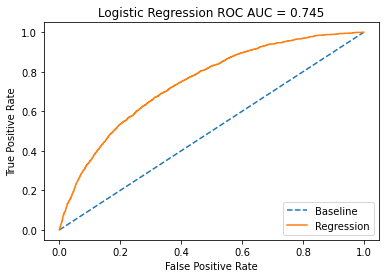

In [78]:
# Строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

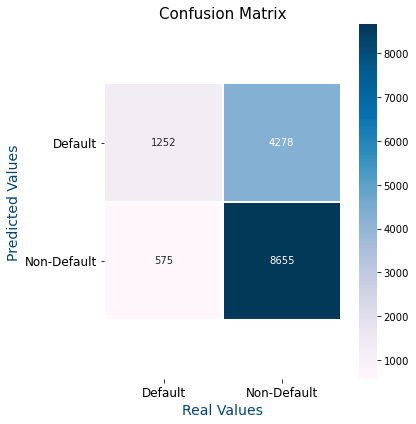

In [79]:
# Выведем confusion_matrix
show_confusion_matrix(y_valid, Y_predict)

In [80]:
# Выведем метрики качества модели
all_metrics(y_valid, Y_predict, Y_predict_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",1252.000000,correctly identified default
"True Negative, TN",8655.000000,correctly identified non-default
"False Positive, FP",4278.000000,incorrectly identified default
"False Negative, FN",575.000000,incorrectly identified non-default
Accuracy,0.671206,Accuracy=(TP+TN)/(P+N)
Precision,0.226401,Precision = TP/(TP+FP)
Recall,0.685276,Recall = TP/P
F1-score,0.340356,Harmonical mean of Precision и Recall


In [81]:
# Обучаем модель на всей обучающей базе
main_model = LogisticRegression( 
                           C=2.7825594022071245, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)
main_model.fit(X, Y)

# Предсказываем значения тестовой базы
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

In [82]:
# Записываем предсказанные моделью вероятности дефолта заемщиков из тестовой базы в отдельный файл
new_sample_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)

new_sample_submission.head(10)

,client_id,default
0,74835,0.200498
1,17527,0.813580
2,75683,0.294055
3,26883,0.418648
4,28862,0.138772
5,99881,0.589646
6,26630,0.807283
7,79934,0.158189
8,16605,0.138343
9,105449,0.127831
